# Callibration for blood oxygen saturation using Stark strip



## import module and declare function

In [1]:

import numpy as np
import matplotlib.pyplot as plt
import os,sys
import scipy.signal as signal
from scipy.interpolate import interp1d
import re
import pandas as pd
import math
plt.style.use('ggplot')
sys.path.insert(0, os.path.abspath('../lib'))

import sig_proc as sp
import file_read

import csv


# Normalize to mv
def value_trans(data):
    data = data*1.2/2097151.0
    return data


def RMS_amp(data):
    squaredData = []
    for val in data:
        squaredData.append(val**2)
    
    ms = np.mean(squaredData)
    rms = math.sqrt(ms)
    return rms


def snr_calc(signal):
    return 20* math.log(np.abs(np.mean(signal)/np.std(signal)),10)



## Main function

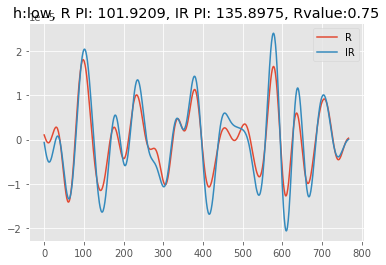

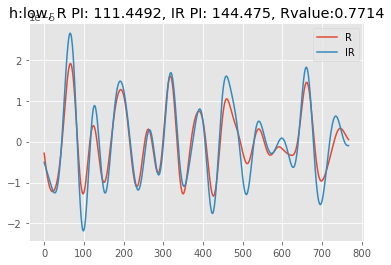

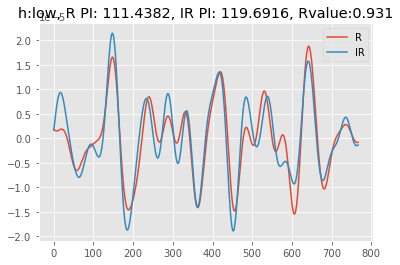

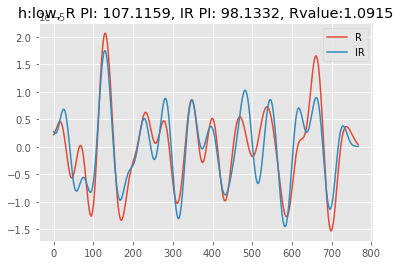

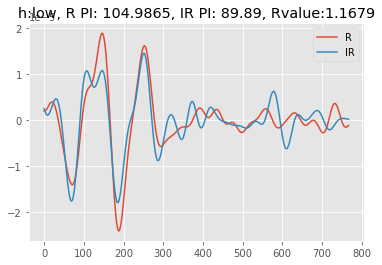

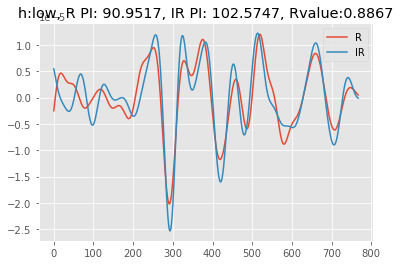

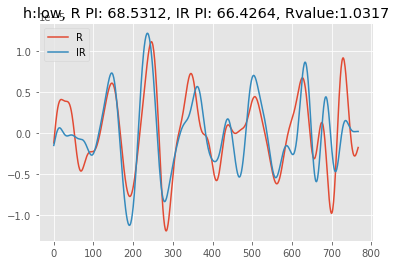

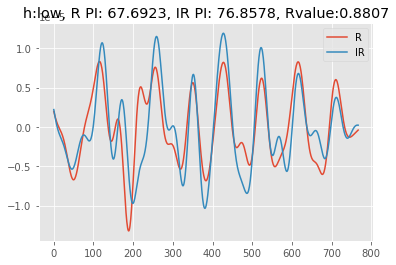

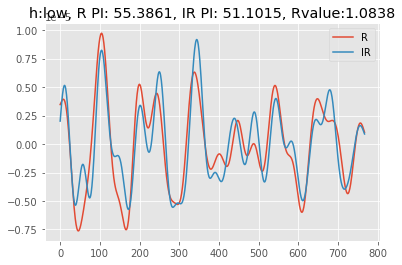

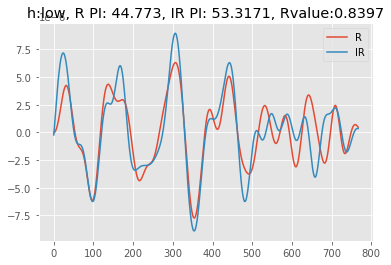

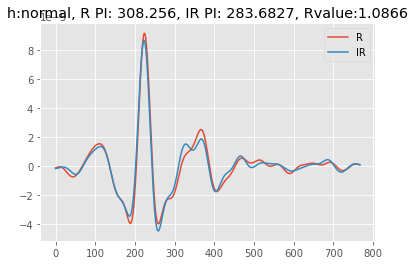

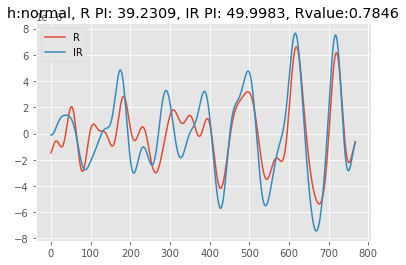

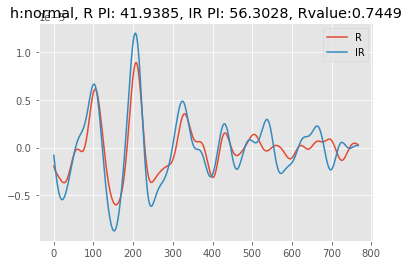

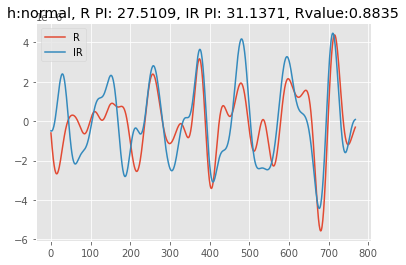

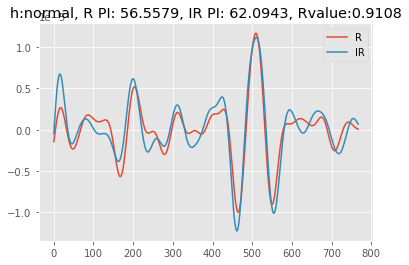

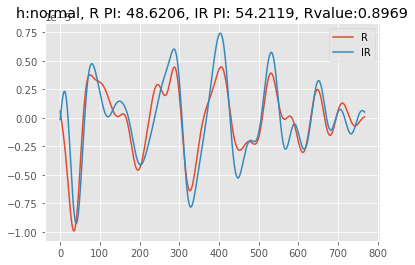

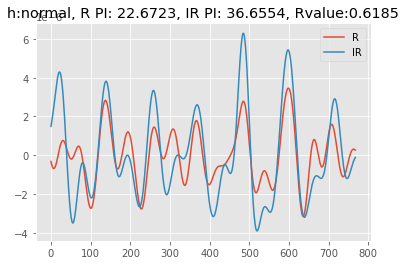

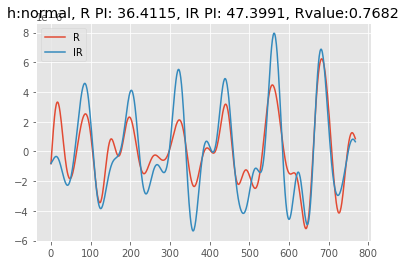

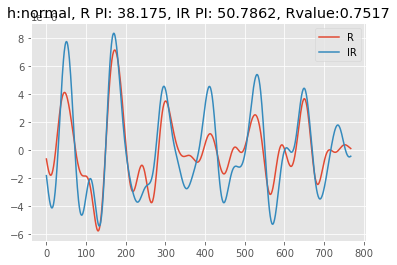

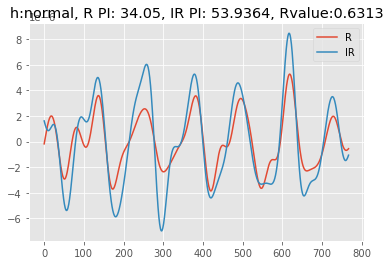

In [59]:
''' Select the duration of PPG segment in seconds'''
start_sec = 26
period = 6
overlap = 2
# overlap = 0
# data_length = len(G_y)/sr
hop_length = period - overlap
num_watching_period = 10
# num_watching_period = int((data_length - overlap)/hop_length) -1

SpO2_table = {
    #'spo2_real':[],
    'spo2':[],
    'criteria':[],
    'R_PI':[],
    'IR_PI':[],
    'R_value':[]
}


sr = 128

# low oxygen level
# file_name = "Jing_0416rawdata/2022-4-16_12-42-31_Stark_CC18A9_RawData.csv"
# normal level
# file_name = "Jing/2022-4-20_15-58-51_Stark_02BFB8_RawData.csv"
# full_file_path = os.path.join("../../data", 'stark',  file_name)
# data = file_read.stark_reader(full_file_path)



# Filter parameters
bp_b, bp_a = sp.bp_filter(0.8, 3, sr, 4)
lp_b, lp_a = sp.lp_filter(3, sr, 4)


head = ['low', 'normal']
dic = {
  'low':{
      'name': "Jing_0416rawdata/2022-4-16_12-42-31_Stark_CC18A9_RawData.csv",
      'Rvalue':[],
      'R_PI':[],
      'IR_PI':[]
      
  },
  'normal':{
      'name':"Jing/2022-4-20_15-58-51_Stark_02BFB8_RawData.csv",
      'Rvalue':[],
      'R_PI':[],
      'IR_PI':[]
      
  }
  
}
for h in head:
    file_name = dic[h]['name']
    full_file_path = os.path.join("../../data", 'stark',  file_name)
    data = file_read.stark_reader(full_file_path)
    
    IR_y = data['PPG_IR']
    R_y = data['PPG_R']
    R_y = np.array(list(map(value_trans, R_y)))
    IR_y = np.array(list(map(value_trans, IR_y)))

    for n in range(num_watching_period):
        t1 = start_sec +  (period-overlap) * n
        t2 = t1 + period
        s1 = int(t1*sr)
        s2 = int(t2*sr )

        '''''''''''''''''''''''''''''''''''''''
        Signal Preprocessing
        '''''''''''''''''''''''''''''''''''''''
        IR_segment = np.array(IR_y[s1:s2])
        R_segment = np.array(R_y[s1:s2])
        
        
        ''' AC component '''
        filt_IR = signal.filtfilt(bp_b,bp_a, IR_segment)
        filt_R = signal.filtfilt(bp_b, bp_a, R_segment)

        ''' DC component '''
        R_DC_component = signal.filtfilt(lp_b,lp_a, R_segment)
        IR_DC_component = signal.filtfilt(lp_b,lp_a, IR_segment)

        ''' Calculate R value by using RMS method'''
        R_divide = filt_R/R_DC_component
        R_RMS = RMS_amp(R_divide)

        IR_divide = filt_IR/IR_DC_component
        IR_RMS = RMS_amp(IR_divide)
        R_value = R_RMS/ IR_RMS
        spo2_value =  0


        SpO2_table['spo2'].append(spo2_value)
        SpO2_table['R_PI'].append(R_RMS)
        SpO2_table['IR_PI'].append(IR_RMS)
        SpO2_table['R_value'].append(R_value)
        
        '''''''''''''''''''''''''''''''''''
        plot filgure
        '''''''''''''''''''''''''''''''''''
        font_size = 14
        fig_size  = (6,4)
            
        plt.figure(figsize=fig_size)
        
        R_PI_mu = np.round(R_RMS*10**6, 4)
        IR_PI_mu = np.round(IR_RMS*10**6, 4)
        plt.title('h:{}, R PI: {}, IR PI: {}, Rvalue:{}'.format(h, R_PI_mu, IR_PI_mu, np.round(R_value,4)))
        plt.plot(filt_R, label='R')
        plt.plot(filt_IR, label='IR')
        plt.legend()

        dic[h]['Rvalue'].append(np.round(R_value,4))
        dic[h]['R_PI'].append(R_PI_mu)
        dic[h]['IR_PI'].append(IR_PI_mu)

        # plt.figure()
        # plt.title('{}, spo2:{}'.format(subject, int(spo2_value+0.5)))
        # x = np.arange(2)
        # width = 0.3
        # plt.bar(x,[R_RMS, IR_RMS], width, bottom=None, align='center',
        #         color=['#E24A33', '#348ABD' ])
        # plt.xticks(x, ['R', 'IR'], fontsize=12)
        # plt.xlabel('LED')
        # plt.ylabel('PI')


Text(0, 0.5, 'R ratio/IR ratio')

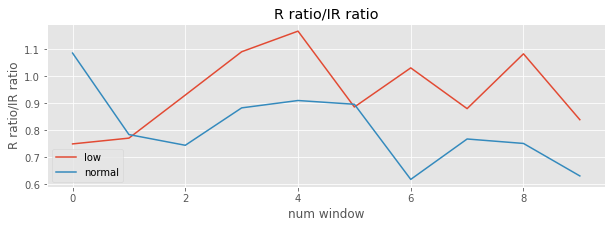

In [60]:

plt.figure(figsize=(10,3))
plt.title('R ratio/IR ratio')
plt.plot(dic['low']['Rvalue'], label='low')
plt.plot(dic['normal']['Rvalue'], label='normal')
plt.legend()
plt.xlabel('num window')
plt.ylabel('R ratio/IR ratio')

(0.0, 500.0)

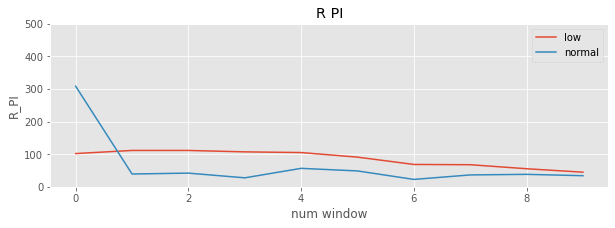

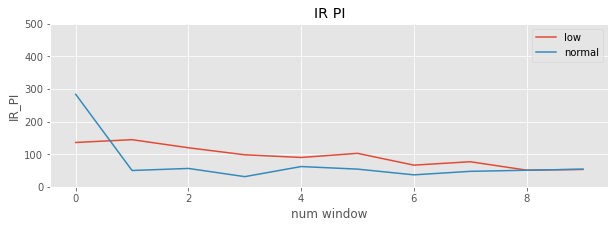

In [61]:
plt.figure(figsize=(10,3))
plt.title('R PI')
plt.plot(dic['low']['R_PI'], label='low')
plt.plot(dic['normal']['R_PI'], label='normal')
plt.legend()
plt.xlabel('num window')
plt.ylabel('R_PI')
plt.ylim(0, 500)

plt.figure(figsize=(10,3))
plt.title('IR PI')
plt.plot(dic['low']['IR_PI'], label='low')
plt.plot(dic['normal']['IR_PI'], label='normal')
plt.legend()
plt.xlabel('num window')
plt.ylabel('IR_PI')
plt.ylim(0, 500)

In [34]:
x = np.arange(2)

rvalue=[0.781, ]
plt.figure()
plt.bar(x, PI_DATAFRAME[LED], width=0.5, bottom=None, align='center',
        color=[
            '#E24A33', 
            '#348ABD', 
            '#988ED5'])
plt.xticks(x, ["normal, "], fontsize=12)
plt.xlabel('subject')
plt.ylabel('PI')
plt.title('lens comparison: ' + LED)
plt.show()


NameError: name 'PI_DATAFRAME' is not defined

<Figure size 432x288 with 0 Axes>

In [17]:
head = ['low', 'normal']
file_names = [ "Jing_0416rawdata/2022-4-16_12-42-31_Stark_CC18A9_RawData.csv", "Jing/2022-4-20_15-58-51_Stark_02BFB8_RawData.csv"]

dic = {
  'low':{
      'name':[file_names[0]],
      'Rvalue':[]
  },
  'normal':{
      'name':[file_names[1]],
      'Rvalue':[]
  }
  
}

dic

{'low': {'name': ['Jing_0416rawdata/2022-4-16_12-42-31_Stark_CC18A9_RawData.csv'],
  'Rvalue': []},
 'normal': {'name': ['Jing/2022-4-20_15-58-51_Stark_02BFB8_RawData.csv'],
  'Rvalue': []}}

In [19]:
dic['low']['Rvalue']

[]